In [1]:
%matplotlib inline
from __future__ import print_function
import numpy
import matplotlib.pyplot as plt

# Abstract
This project aims to analyze different numerical methods to solving the viscid Burgers Equation which is a fundamental partial differential equation occurring in various areas of applied mathematics, such as fluid mechanics, traffic flow. The viscid Burgers equation is also considered as a simplified form of the Navier–Stokes equation due to the presence of nonlinear convection term and the linear viscosity term.

The project solves the equation using explicit method, implicit method and spectral method with error analysis and stability analysis for each method

# 1D Burgers equation with periodic boundary

$$
\frac{\partial u}{\partial t} +u \frac{\partial u}{\partial x} = \nu \frac{\partial  u^2}{\partial ^2 x}
$$

$$
u(0)=u(L)=0
$$

$$
IC:u(x,0)=sin(2 \pi x)
$$

We solve the Burgers equation by transforming it into a linear heat equation via the Cole–Hopf transformation.

Write the orgininal function as 
$$\frac{\partial u}{\partial t} +\frac{\partial}{\partial x}(\frac{u^2}{2}-\nu \frac{\partial u}{\partial x})=0$$

Then we can write $u = \zeta_x$, get $$\frac{u^2}{2}-\nu \frac{\partial u}{\partial x} = -\zeta_t$$

Write $$\epsilon (x,t) = e^{-\frac{\zeta}{2 \nu}}$$
Then $$\zeta = -2\nu \log \epsilon$$

Substitute this back, we get the heat equation $$\epsilon_t = \nu \epsilon_{xx}$$

Now solution u can be written as $$u(x,t)=\zeta_x = -2\nu \frac{\epsilon_x}{\epsilon}$$

initial condition $$u(x,0) = f(x)= -2\nu \frac{\epsilon_x (x,0)}{\epsilon (x,0)}$$

$$\epsilon(x,0) = \epsilon(0,0) exp({\frac{-\int_0^x u(x',0)dx'}{2\nu}})$$

For boundary conditions

$$u(0,t) = -2\nu \frac{\epsilon_x (0,t)}{\epsilon} ~~~~\rightarrow ~~~~\epsilon_x + \frac{u(0,t)}{2\nu} = 0$$
$$u(L,t) = -2\nu \frac{\epsilon_x (L,t)}{\epsilon} ~~~~\rightarrow ~~~~\epsilon_x + \frac{u(L,t)}{2\nu} = 0$$

For our analysis, we set $u(x,0) = f(x) = sin(2\pi x)$

boundary conditions $u(0,t)=u(1,t) = 0$

Now we can solve the heat equation $$\epsilon_t = \nu \epsilon_{xx}$$ 

With Initial condition:

$$\epsilon(x,0) = exp({\frac{-\int_0^x f(x')dx'}{2\nu}} )=exp({\frac{-\int_0^x sin(2\pi x')dx'}{2\nu}})=exp({\frac{cos(2\pi x)-1}{4 \pi \nu}})$$

And Neumann boundary conditions:

$$\epsilon_x (0,t) =\epsilon_x (1,t) = 0$$

$$
\epsilon(x,t) = a_0 + \sum_{n=1}^{\infty} a_n e^{-n^2 \pi^2 \nu t} cos(n\pi x)
$$

$$
a_0 = \int_0^1 \epsilon (x,0)dx = \int_0^1 exp({\frac{cos(2\pi x)-1}{4 \pi \nu}})dx
$$

$$
a_n = 2 \int_0^1 \epsilon (x,0) cos(n\pi x)dx = 2 \int_0^1 exp({\frac{cos(2\pi x)-1}{4 \pi \nu}}) cos(n\pi x)dx
$$

$$
\epsilon_x = \sum_{n=1}^{\infty} -n \pi a_n e^{-n^2 \pi^2 \nu t} sin(n\pi x)
$$

In [2]:
#Visualizing the equation
#problem set up
nu = 0.01
m = 200
x = numpy.linspace(0, 1, m)
U_0 = numpy.sin(2*numpy.pi*x)

In [3]:
import scipy.integrate as integrate
# Define the true solution
def ufunc(x,t,nu):
    """Analytic solution for viscid burgers eqution with periodic boundary condions
    :Input:
    - *nu* (float) Diffusion coefficient
    - *t* (float) Time to integrate to (t_0 set to zero)
    - *x* (numpy.ndarray) points to be evaluated
    :Output:
    - (numpy.ndarray) Solution at time t
    """
    #Calculate the coefficients an
    N=30
    a = numpy.empty(N)
    an = integrate.quad(lambda x: numpy.exp((numpy.cos(2* numpy.pi *x)-1)/(4*numpy.pi*nu)), 0, 1)
    a[0] = an[0]-an[1]
    for n in range(1,N):
        an=integrate.quad(lambda x: numpy.exp((numpy.cos(2* numpy.pi *x)-1)/(4*numpy.pi*nu)) * numpy.cos(n*numpy.pi*x), 0, 1)
        a[n] = (an[0] - an[1])*2
    
    #Calculate u
    fx = 0
    f =a[0]
    for n in range(1,N):
        fx +=  n*numpy.pi*a[n]*numpy.exp(-(n*numpy.pi)**2 *nu*t) *numpy.sin(n*numpy.pi*x)
        f += a[n]*numpy.exp(-(n*numpy.pi)**2 *nu*t) *numpy.cos(n*numpy.pi*x)
        
    return 2*nu*fx/f
    

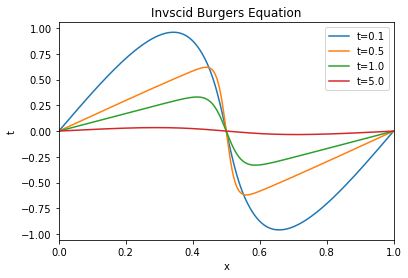

In [4]:
#Plot the true solution develop with time
t_range = numpy.array([0.1,0.5,1.0,5.0])
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
for t in t_range:
    axes.plot(x, ufunc(x,t,nu),label = 't=' + str(t))



axes.set_xlim((0, 1.0))
axes.set_title("Invscid Burgers Equation")
axes.set_xlabel("x")
axes.set_ylabel("t")
axes.legend()


# Physical interpretation

From the above graph we can see a wave convects from left to right. The point with higher value of convects faster than point with lower value. 

# Explicit Method  - center in space and forward in time

$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} + U^n_j \frac{U^n_{j+1} - U^n_{j-1}}{2 \Delta x}= \nu \frac{U^n_{j+1} -2U^n_j + U^n_{j-1}}{\Delta x^2} 
$$

Reorganize the equation, we get

$$\begin{align}
    U^{n+1}_j &= U^n_j - \frac{\Delta t}{2 \Delta x} U^n_j (U^n_{j+1} - U^n_{j-1}) + \nu \frac{\Delta t}{\Delta x^2}(U^n_{j+1}-2U^n_j + U^n_{j-1}) \\
    &= (1- 2\nu \frac{\Delta t}{\Delta x^2}) U^n_j- \frac{\Delta t}{2 \Delta x} U^n_j (U^n_{j+1} - U^n_{j-1}) + \nu \frac{\Delta t}{\Delta x^2}(U^n_{j+1}+ U^n_{j-1})
\end{align}$$

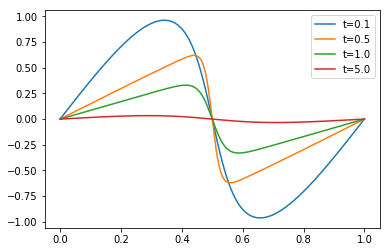

In [5]:
def burgers_explicit(U_0,m,t_0,t_f,nu):
    """Solve the burgers equation with periodic boundary using explicit
    
    :Input:
     - *m* (int) Number of points use to discretize the domain. 
     - *nu* (float) Diffusion coefficient
     - *t_0* (float) Starting time
     - *t_final* (float) Time to integrate to
     - *U_0* (numpy.ndarray) Initial condition at time t_0
     
    :Output:
     - (numpy.ndarray) Solution at time t_final.
    """
    x=numpy.linspace(0,1,m)
    delta_x = x[1]-x[0]
    dt = delta_x**2/(2*nu)
    N=int((t_f-t_0)/dt+1)
    delta_t = (t_f-t_0)/N
    u=U_0.copy()
    for n in range(N):
        un = u.copy()
        for i in range(1, m-1):
            u[i] = un[i] - un[i] * delta_t / (2 * delta_x) *(un[i+1] - un[i-1]) + nu * delta_t / delta_x**2 *\
                    (un[i+1] - 2 * un[i] + un[i-1])
            u[-1] =u[0] = 0
    return  u

t_0=0
m=200
nu = 0.01
x = numpy.linspace(0, 1, m)
U_0 = numpy.sin(2*numpy.pi*x)
t_range = numpy.array([0.1,0.5,1.0,5.0])
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
for t_f in t_range:
    axes.plot(x, burgers_explicit(U_0,m,t_0,t_f,nu),label = 't=' + str(t_f))

axes.legend()
plt.show()


# Von Neumann Analysis

$$ U^{n+1}_j = (1- 2\nu \frac{\Delta t}{\Delta x^2}) U^n_j- \frac{\Delta t}{2 \Delta x} U^n_j (U^n_{j+1} - U^n_{j-1}) + \nu \frac{\Delta t}{\Delta x^2}(U^n_{j+1}+ U^n_{j-1})$$

Setting $U^n_j = e^{i j \Delta x \xi}$ we have

$$\begin{align}
U_j^{n+1} &= (1- 2\nu \frac{\Delta t}{\Delta x^2}) U^n_j- \frac{\Delta t}{2 \Delta x} U^n_j (e^{i \Delta x \xi}U^n_j - e^{-i \Delta x \xi}U^n_j) + \nu \frac{\Delta t}{\Delta x^2}(e^{i \Delta x \xi}U^n_j+e^{-i \Delta x \xi} U^n_j) \\
&= (1- 2\nu \frac{\Delta t}{\Delta x^2})U^n_j- \frac{\Delta t}{2 \Delta x} (U^n_j)^2 (e^{i \Delta x \xi} - e^{-i \Delta x \xi}) + \nu \frac{\Delta t}{\Delta x^2}U^n_j(e^{i \Delta x \xi}+e^{-i \Delta x \xi}) \\
&= (1- 2\nu \frac{\Delta t}{\Delta x^2}+ \nu \frac{2\Delta t}{\Delta x^2} cos(\Delta x \xi))U^n_j- \frac{\Delta t}{ \Delta x} (U^n_j)^2 sin( \Delta x \xi) 
\end{align}$$

that, since $-1 \leq \cos (\xi \Delta x) \leq 1$ for all $\xi$

$$
    1- 4\nu \frac{\Delta t}{\Delta x^2} \leq g(\xi) \leq 1 \quad \forall \xi.
$$

Therefore, we know the method is stable if 
$$
    \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2\nu}
$$

# Error Analysis

Use taylor's expansion
$$
U_j^{n+1} = u + \Delta t u_t +\frac{1}{2} \Delta t^2 u_{tt}
$$

$$
U_{j+1}^n - 2U_j^n +U_{j-1}^n = \Delta x^2 u_xx +\frac{1}{12} \Delta x^4 u_{xxxx}
$$

$$
U_{j+1}^n - U_{j-1}^n = 2 \Delta x u_x +\frac{1}{3} \Delta x^3 u_{xxx}
$$

$$
u + \Delta t u_t +\frac{1}{2} \Delta t^2 u_{tt}= u + \nu \frac{\Delta t}{\Delta x^2}(\Delta x^2 u_{xx} +\frac{1}{12} \Delta x^4 u_{xxxx}) - \frac{\Delta t}{2 \Delta x^2}u(2 \Delta x u_x +\frac{1}{3} \Delta x^3 u_{xxx})
$$

$$
u_t +\frac{1}{2} \Delta t u_{tt}=  \nu (u_{xx} +\frac{1}{12} \Delta x^2 u_{xxxx}) - u u_x - \frac{1}{6} \Delta x^2 u u_{xxx}
$$

$$
u_t + u u_x -\nu u_{xx} =-\frac{1}{2} \Delta t u_{tt}+  \nu \frac{1}{12} \Delta x^2 u_{xxxx} - \frac{1}{6} \Delta x^2 u u_{xxx}
$$

Therefore, the method should be second order in space and second order in time.

Text(0,0.5,'$|u(x) - U|$')

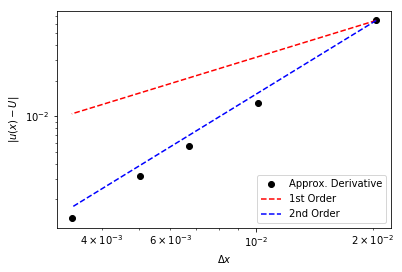

In [6]:
t_0=0.0
t_f=0.5
nu=0.01


order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

m_range = [50,100,150, 200,300]

delta_x = numpy.empty(len(m_range))
error = numpy.empty(len(m_range))
for (i, m) in enumerate(m_range):

    x = numpy.linspace(0.0, 1, m)
    delta_x[i] = 1 / (m-1)
    U_0 = numpy.sin(2*numpy.pi*x)
    U_true =  numpy.asarray([ufunc(x0,t_f,nu) for x0 in x])
    

    # Compute solution
    U = burgers_explicit(U_0,m,t_0,t_f,nu)
    error[i] = numpy.linalg.norm(U - U_true, ord=numpy.infty)
       
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc=4)

axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")

# Stability Analysis with $\nu$

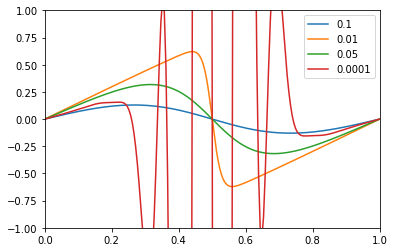

In [7]:
nu_range = numpy.array([0.1,0.01,0.05,0.0001])
m = 200
x = numpy.linspace(0, 1, m)
U_0 = numpy.sin(2*numpy.pi*x)
t=0.5
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
for nu in nu_range:
    U=burgers_explicit(U_0,m,0.0,t,nu)
    
    axes.plot(x, U, label = nu)
    axes.set_xlim(0.0,1.0)
    axes.set_ylim(-1.0,1.0)
    axes.legend()

We see the lower the kinematic viscosity, the higher the value of u. 

And the explicit method is not stable for small $\nu$

# Implicit Method - Crank-Nicolson


$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} + \frac{1}{4 \Delta x}(U^{n+1}_j (U^n_{j+1} - U^n_{j-1}) +U^{n}_j (U^{n+1}_{j+1} - U^{n+1}_{j-1}) )=  \frac{\nu}{2\Delta x^2} (U^n_{j+1} -2U^n_j + U^n_{j-1} + U^{n+1}_{j+1} -2U^{n+1}_j + U^{n+1}_{j-1})
$$


Reorganize, we get

$$
(-r + p u_j^n) u_{j+1}^{n+1} + (2r +1+pu_{j+1}^n - p u_{j-1}^n) u_j^{n+1} -(r+pu_j^n)u_{j-1}^{n+1} = r u_{j+1}^{n} + (1-2r) u_j^{n} -ru_{j-1}^{n}
$$

With 
$$r=\frac{\nu \Delta t}{2 \Delta x^2}$$

$$p=\frac{\Delta t}{4 \Delta x}$$

In [17]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg


t_0=0
t_f=0.5

m=200
nu = 0.01
x = numpy.linspace(0, 1, m)
U_0 = numpy.sin(2*numpy.pi*x)


def implicit(U_0,m,t_0,t_f,nu):
    """Solve the burgers equation with periodic boundary using implicit
    
    :Input:
     - *m* (int) Number of points use to discretize the domain. 
     - *nu* (float) Diffusion coefficient
     - *t_0* (float) Starting time
     - *t_final* (float) Time to integrate to
     - *U_0* (numpy.ndarray) Initial condition at time t_0
     
    :Output:
     - (numpy.ndarray) Solution at time t_final.
    """
    # Initial condition
    x = numpy.linspace(0, 1, m)
    delta_x = x[1]- x[0]
    dt = 0.1*delta_x
    N=int((t_f-t_0)/dt+1)
    delta_t = (t_f-t_0)/N
    U = U_0.copy()

    r = nu * delta_t / (2*delta_x**2)
    p = delta_t/(4*delta_x)

    B = numpy.zeros((m, m))
    diagonal = numpy.ones(m)
    B += numpy.diag(diagonal * (1-2*r), 0)
    B += numpy.diag(diagonal[:-1]*r, 1)
    B += numpy.diag(diagonal[:-1]*r, -1)

    # Time stepping loop
    for n in range(N):
        # Build solving matrix
        d= numpy.zeros(m)
        d[0] = U[1]-U[0]
        d[1:-1] = U[2:] - U[:-2]
        d[-1] = U[-1] - U[-2]
        b = numpy.ones(m) * (1+2*r)+ p *d
        c = -U[1:]*p - numpy.ones(m-1)*r
        a = U[:-1]*p - numpy.ones(m-1)*r    


        A = numpy.zeros((m, m))

        A += numpy.diag(b, 0)
        A += numpy.diag(a, 1)
        A += numpy.diag(c, -1)

        


        # Construct right-hand side
        b = B.dot(U)
        # Solve system
        U = numpy.linalg.solve(A, b)
    return U
    
    

    
    


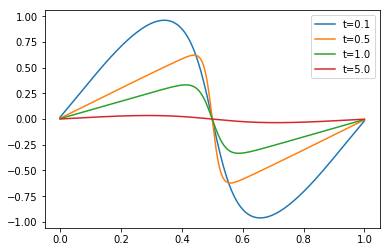

In [18]:
t_0=0
m=200
nu = 0.01
x = numpy.linspace(0, 1, m)
U_0 = numpy.sin(2*numpy.pi*x)
t_range = numpy.array([0.1,0.5,1.0,5.0])
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
for t_f in t_range:
    axes.plot(x, implicit(U_0,m,t_0,t_f,nu),label = 't=' + str(t_f))

axes.legend()
plt.show()


# Error Analysis

$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} + \frac{1}{4 \Delta x}(U^{n+1}_j (U^n_{j+1} - U^n_{j-1}) +U^{n}_j (U^{n+1}_{j+1} - U^{n+1}_{j-1}) )=  \frac{\nu}{2\Delta x^2} (U^n_{j+1} -2U^n_j + U^n_{j-1} + U^{n+1}_{j+1} -2U^{n+1}_j + U^{n+1}_{j-1})
$$

$$
U_j^{n+1} -U_j^n = \Delta t u_t +\frac{1}{2} \Delta t^2 u_{tt}
$$

$$
U_{j+1}^n - 2U_j^n +U_{j-1}^n = \Delta x^2 u_xx +\frac{1}{12} \Delta x^4 u_{xxxx}
$$

$$
U_{j+1}^n - U_{j-1}^n = 2 \Delta x u_x +\frac{1}{3} \Delta x^3 u_{xxx}
$$

$$
U_{j+1}^{n+1} - 2U_j^{n+1} +U_{j-1}^{n+1} = \Delta x^2 u_xx +\frac{1}{3} \Delta t^3 u_{ttt} + \Delta x^2 \Delta t u_{xxt}
$$

$$
U_{j+1}^{n+1} - U_{j-1}^{n+1} = 2 \Delta x u_x +2 \Delta x \Delta t u_{xt} + \frac{1}{3} \Delta x^3 u_{xxx} + \Delta x \Delta t^2 u_{xtt}
$$


$$
    \frac{U^{n+1}_j - U^n_j}{\Delta t} + \frac{1}{4 \Delta x}(U^{n+1}_j (U^n_{j+1} - U^n_{j-1}) +U^{n}_j (U^{n+1}_{j+1} - U^{n+1}_{j-1}) ) - \frac{\nu}{2\Delta x^2} (U^n_{j+1} -2U^n_j + U^n_{j-1} + U^{n+1}_{j+1} -2U^{n+1}_j + U^{n+1}_{j-1})$$
    
$$ = (u_t - \nu u_{xx} + u u_x)_t \frac{\Delta t}{2} + O(\Delta t^2 , \Delta x^2)$$

Text(0,0.5,'$|u(x) - U|$')

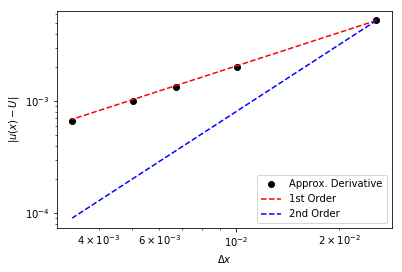

In [19]:
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

m_range = [40,100,150, 200,300]

delta_x = numpy.empty(len(m_range))
error = numpy.empty(len(m_range))
for (i, m) in enumerate(m_range):

    x = numpy.linspace(0.0, 1, m)
    delta_x[i] = 1 / (m-1)
    U_0 = numpy.sin(2*numpy.pi*x)
    U_true =  ufunc(x,t_f,nu)
    

    # Compute solution
    U = implicit(U_0,m,t_0,t_f,nu)
    error[i] = numpy.linalg.norm(U - U_true, ord=numpy.infty)
       
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")

axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)

axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$|u(x) - U|$")

# Stability Analysis with $\nu$

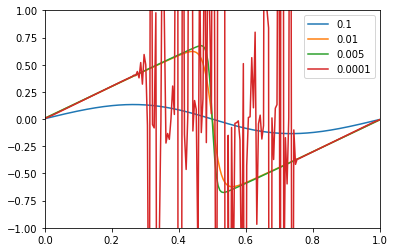

In [11]:
nu_range = numpy.array([0.1,0.01,0.005,0.0001])
m = 200
x = numpy.linspace(0, 1, m)
U_0 = numpy.sin(2*numpy.pi*x)
t=0.5
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
for nu in nu_range:
    U=implicit(U_0,m,0.0,t,nu)
    
    axes.plot(x, U, label = nu)
    axes.set_xlim(0.0,1.0)
    axes.set_ylim(-1.0,1.0)
    axes.legend()

Implicit method is also not stable for small $\nu$

### Spectral Methods

Since we are using periodic boundary conditions and a smooth solution is expected.  We can try to solve the problem using spectral method

Write the original problem as 

$$
\frac{\partial u}{\partial t} +\frac{\partial}{\partial x}(\frac{u^2}{2}) = \nu \frac{\partial  u^2}{\partial ^2 x}
$$

we denote $F(x) = \frac{u^2}{2}$ to handle the nonlinear term

$$
    \widehat{(u_x)} = i \xi \hat{u~}.
$$

$$
    \widehat{\frac{u^{n+1}-u^n}{\Delta t}} +\widehat{F_x} = \nu \widehat{u_{xx}}
$$

$$
   \widehat {u^{n+1}}=\widehat{ u^n} - \Delta t ik \widehat{F} + \Delta t (ik)^2 \nu \widehat{u^n}
$$

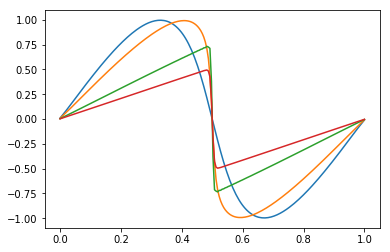

In [12]:
import numpy.fft as fft
t_0=0
t_f=10

m=200
x = numpy.linspace(0, 1, m)
nu = 0.01
def spectral(m,nu,t_0,t_f):
    x = numpy.linspace(0, 1, m)
    delta_x = 1/(m-1)
    dt = delta_x
    N=int((t_f-t_0)/dt+1)
    delta_t = (t_f-t_0)/N


    L = 1.0
    M = fft.fftfreq(m, 1.0 / m)
    M_odd = M[numpy.nonzero(numpy.ravel(numpy.mod(M, 2)))]
    k = M / L

    u=  numpy.sin(2*numpy.pi*x)


    for n in range(N):
        ur=fft.fft(u)- delta_t*1.0j * k * fft.fft(u**2)/2 - delta_t * k**2 *nu *fft.fft(u)
        u = fft.ifft(ur).real
    return u

    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, spectral(m,nu,t_0,0.5))
axes.plot(x, spectral(m,nu,t_0,1))
axes.plot(x, spectral(m,nu,t_0,3))
axes.plot(x, spectral(m,nu,t_0,5))

# Stability Analysis with $\nu$

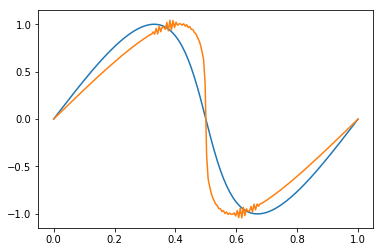

In [13]:
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, spectral(m,0.0001,t_0,0.5))
axes.plot(x, spectral(m,0.0001,t_0,1))

# Conclusion

This project tried three different methods
Both explicit and implicit method have second order convergence. Neither of these two methods can handle small $\nu$.

But explicit method requires $\frac{\Delta t}{\Delta x^2} \leq \frac{1}{2\nu}$$ to be stable, while implicit method is always stable. 

Spectral method has a better performance with small $\nu$

Reference:

analytic solution cited from :Belal M., Hasan N. (2016) Solution of Viscous Burgers Equation Using a New Flux Based Scheme. In: Cushing J., Saleem M., Srivastava H., Khan M., Merajuddin M. (eds) Applied Analysis in Biological and Physical Sciences. Springer Proceedings in Mathematics & Statistics, vol 186. Springer, New Delhi


crank-nicolson theory: Crank-Nicolson Type Method for Burgers Equation[Sachin S. Wani and Sarita H. Thakar]

spectral theory:https://math.stackexchange.com/questions/1732058/solving-viscous-burgers-using-spectral-method


Lecture notes